In [1]:
import os
import torch
import zipfile
import torchvision
from torch import nn
from enum import Enum
from pathlib import Path
from tqdm.auto import tqdm
from torchinfo import summary
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision import datasets, transforms
from torchmetrics.classification import MulticlassAccuracy

In [2]:
backbone = "vgg16_bn"
torch_home = '/kaggle/working/torchvision_models'
os.environ['TORCH_HOME'] = torch_home
os.makedirs(torch_home, exist_ok=True)

In [ ]:
class FineTuneType(Enum):
    NEW_LAYERS = 1
    CLASSIFIER = 2
    ALL = 3

In [ ]:
class Food(nn.Module):
    def __init__(self, backbone, loaded_pretrained_model):
        super().__init__()
        self.pretrained_model = None
        self.classifier_layers = []
        self.new_layers = []

        if backbone:
            if loaded_pretrained_model:
                self.pretrained_model = torchvision.models.vgg16_bn(weights=torchvision.models.VGG16_BN_Weights.IMAGENET1K_V1)
            else:
                self.pretrained_model = torchvision.models.vgg16_bn(weights=None)
            self.classifier_layers = [self.pretrained_model.classifier]
            self.pretrained_model.classifier[6] = nn.Linear(in_features=4096, out_features=3)
            self.new_layers = [self.pretrained_model.classifier[6]]
        
        self.register_buffer("train_metrics", torch.tensor([float("inf"), 0.0]))
        self.register_buffer("val_metrics", torch.tensor([float("inf"), 0.0]))

    def forward(self, x):
        return self.pretrained_model(x)
    
    def update_metrics(self, run_type, loss, accuracy):
        metrics = self.train_metrics if run_type == "train" else self.val_metrics
        if loss is not None:
            metrics[0] = loss
        if accuracy is not None:
            metrics[1] = accuracy

    def get_metrics(self, run_type):
        metrics = self.train_metrics if run_type == "train" else self.val_metrics
        return dict(zip(["loss", "accuracy"], metrics.tolist()))
    
    def fine_tune(self, what: FineTuneType):
        m = self.pretrained_model
        for p in m.parameters():
            p.requires_grad = False

        if what is FineTuneType.NEW_LAYERS:
            for l in self.new_layers:
                for p in l.parameters():
                    p.requires_grad = True
        elif what is FineTuneType.CLASSIFIER:
            for l in self.classifier_layers:
                for p in l.parameters():
                    p.requires_grad = True
        else:
            for p in m.parameters():
                p.requires_grad = True

    def train_one_epoch(self, loader, optimizer, epoch):
        criterion = nn.CrossEntropyLoss()
        running_loss = 0.0
        running_accuracy = 0.0
        num_batches = 0

        for input, targets in loader:
            outputs = self(input)
            loss = criterion(outputs, targets)

            running_loss, num_batches = running_loss + loss.item(), num_batches + 1
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"[{epoch}] Train Loss: {running_loss / num_batches:.5f}")
        return running_loss / num_batches, running_accuracy / num_batches
    
    def evaluate(self, loader, metric, epoch, run_type):
        criterion = nn.CrossEntropyLoss()
        running_loss = 0.0
        running_accuacy = 0.0
        num_batches = 0
        for inputs, targets in loader:
            outputs = self(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item()
            num_batches += 1
            running_accuacy += metric(outputs, targets)

        print(f"[{epoch}] {run_type} Loss: {running_loss / num_batches:.5f}, Accuracy: {running_accuacy / num_batches:5f}")
        return running_loss / num_batches, running_accuacy / num_batches
    
    def train_multiple_epoch_and_save_best_checkpoints(
            self,
            train_loader,
            val_loader,
            accuracy,
            optimizer,
            scheduler,
            epoch,
            filename,
            training_run
    ):
        best_val_accuaracy = self.get_metrics("val")['accuracy']
        for epoch in tqdm(range(1, epoch + 1)):
            self.train()
            self.train_one_epoch(train_loader, optimizer, epoch)

            self.eval()
            with torch.inference_mode():
                train_loss, train_acc = self.evaluate(train_loader, accuracy, epoch, "Train")
                # training_run.train_loss.append(train_loss)
                # training_run.train_acc.append(train_acc)

            self.eval()
            with torch.inference_mode():
                val_loss, val_acc = self.evaluate(val_loader, accuracy, epoch, "val")
                # training_run.val_loss.append(val_loader)
                # training_run.val_acc.append(val_acc)
                if val_acc > best_val_accuaracy:
                    print(f"Current Validation accuracy {val_acc*100.0:.2f} is better tha the previous best of {best_val_accuaracy*100:.2f}. saving checkpoint>>>")
                    self.update_metrics("train", train_loss, train_acc)
                    self.update_metrics("val", val_loss, val_acc)
                    torch.save(self.state_dict(), filename)
                    best_val_accuaracy = val_acc

            scheduler.step()

    def get_optimizer_params(self):
        options = []
        lr = 0.0001
        options.append({
            'params': self.pretrained_model.classifier.parameters(),
            'lr': lr
        })

        final_lr = lr / 1000.0
        diff_lr = final_lr - lr
        lr_step = diff_lr / 44.0
        for i in range(43, -1, -1):
            options.append({
                'params': self.pretrained_model.features[i].parameter(),
                'lr': lr + lr_step * (44-i)
            })

        return options

print(f"Backbone: {backbone}")
food_test = Food(backbone=backbone, loaded_pretrained_model=False)
x = torch.rand(4, 3, 244, 224)
y = food_test(x)
print(x.shape, y.shape)



Backbone: vgg16_bn
torch.Size([4, 3, 244, 224]) torch.Size([4, 3])


In [5]:
data_path = Path("data")
image_path = data_path / "pizza_steak_sushi"
if data_path.is_dir():
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip") as zip_ref:
        zip_ref.extractall(data_path)

In [6]:
import random

image_list = list(image_path.glob("*/*/*.jpg"))
random_image_list = random.choice(image_list)

random_image_list

train_dir = image_path / "train"
test_dir = image_path / "test"

In [7]:
train_data_transform = transforms.Compose([
    transforms.Resize(size=(244, 224)),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.ColorJitter(brightness=0.3, contrast=0.3),
    torchvision.transforms.RandomAffine(degrees=30, shear=20),
    # Resize image and normalize pixels using the provided mean and standard deviation
    # torchvision.models.VGG16_BN_Weights.IMAGENET1K_V1.transforms(),
    ToTensor()
])

test_data_transform = transforms.Compose([
    transforms.Resize(size=(244, 224)),
    # torchvision.models.VGG16_BN_Weights.IMAGENET1K_V1.transforms(),
    ToTensor()
    
])

In [8]:
import matplotlib.pyplot as plt

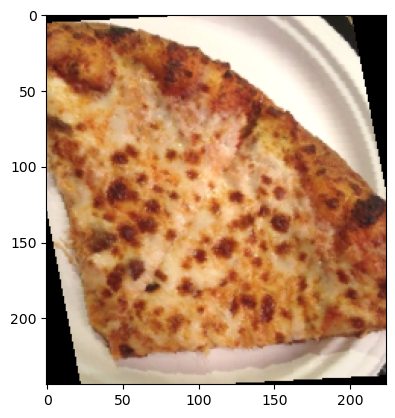

In [9]:
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=train_data_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=train_data_transform,
                                 target_transform=None)

image, label = test_data[0]
plt.imshow(image.permute(1, 2, 0))

In [10]:
BATCH_SIZE = 8
NUM_WORKERS = 8
food_train_loader = DataLoader(dataset=train_data,
                          batch_size=BATCH_SIZE,
                          num_workers=NUM_WORKERS,
                          shuffle=True)

food_test_loader = DataLoader(dataset=test_data,
                         batch_size=BATCH_SIZE,
                         num_workers=NUM_WORKERS,
                         shuffle=False)

image, label = next(iter(food_test_loader))
image

tensor([[[[0.7961, 0.7569, 0.6980,  ..., 0.0000, 0.0000, 0.0000],
          [0.7490, 0.6980, 0.6431,  ..., 0.0000, 0.0000, 0.0000],
          [0.7529, 0.6980, 0.6471,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.5961, 0.5961, 0.5961],
          [0.0000, 0.0000, 0.0000,  ..., 0.5961, 0.5961, 0.6000],
          [0.0000, 0.0000, 0.0000,  ..., 0.6000, 0.5961, 0.5961]],

         [[0.7725, 0.7255, 0.6588,  ..., 0.0000, 0.0000, 0.0000],
          [0.7176, 0.6549, 0.5882,  ..., 0.0000, 0.0000, 0.0000],
          [0.7216, 0.6588, 0.5961,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.5412, 0.5451, 0.5451],
          [0.0000, 0.0000, 0.0000,  ..., 0.5451, 0.5451, 0.5490],
          [0.0000, 0.0000, 0.0000,  ..., 0.5490, 0.5490, 0.5569]],

         [[0.7137, 0.6706, 0.6078,  ..., 0.0000, 0.0000, 0.0000],
          [0.6588, 0.6078, 0.5451,  ..., 0.0000, 0.0000, 0.0000],
          [0.6667, 0.6078, 0.5529,  ..., 0

In [11]:
def transfer_learning_on_backbone(backbone, feature_extract_epochs, fine_tune_epochs):
    # training_runs = {}
    best_cp_path = f'{backbone}_food.pt'
    print(f"Runnning feature extraction on a {backbone} for {feature_extract_epochs} epochs.\n")
    model_0 = Food(backbone=backbone, loaded_pretrained_model=True)

    optimizer = torch.optim.Adam(model_0.parameters())
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.3)
    accuracy = MulticlassAccuracy(num_classes=3, average='micro')

    print(f"Accuracy of {backbone}-base pre-trained model with last layer replaced")
    model_0.eval()
    model_0.evaluate(food_test_loader, accuracy, 0, "val")
    model_0.fine_tune(FineTuneType.NEW_LAYERS)

    best_test_accuracy = 0.0
    # training_run = TrainingRun()
    # training_runs[backbone] = training_run

    model_0.train_multiple_epoch_and_save_best_checkpoints(
        food_train_loader,
        food_test_loader,
        accuracy,
        optimizer,
        scheduler,
        feature_extract_epochs,
        best_cp_path,
        '',
    )

    print(f"Done with feature extraction for {backbone}-based model. Ran for {feature_extract_epochs} epochs.")

    best_val_accuracy = model_0.get_metrics("val")['accuracy']
    print(f"[{backbone}] Best val accuracy after accuracy after feature extraction is")
    print(f"Running fine-tuning for {fine_tune_epochs} epochs")

    model_0.fine_tune(FineTuneType.ALL)

    optimizer = torch.optim.Adam(model_0.get_optimizer_params(), lr=1e-8)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.7)

    model_0.train_multiple_epoch_and_save_best_checkpoints(
        food_train_loader,
        food_test_loader,
        accuracy,
        optimizer,
        scheduler,
        fine_tune_epochs,
        best_cp_path,
        '',
    )

    best_val_accuracy = model_0.get_metrics("val")['accuracy']
    print(f"[{backbone}] Best val accuracy after fine-tuning is {best_val_accuracy}\n")

transfer_learning_on_backbone(backbone, feature_extract_epochs=16, fine_tune_epochs=8)

Runnning feature extraction on a vgg16_bn for 16 epochs.

Accuracy of vgg16_bn-base pre-trained model with last layer replaced
[0] val Loss: 1.08516, Accuracy: 0.366905


  0%|          | 0/16 [00:00<?, ?it/s]

[1] Train Loss: 1.14929
[1] Train Loss: 1.10214, Accuracy: 0.374583
[1] val Loss: 1.09864, Accuracy: 0.390000
Current Validation accuracy 39.00 is better tha the previous best of 0.00. saving checkpoint>>>
[2] Train Loss: 1.13232
[2] Train Loss: 2.16916, Accuracy: 0.448333
[2] val Loss: 1.83803, Accuracy: 0.455238
Current Validation accuracy 45.52 is better tha the previous best of 39.00. saving checkpoint>>>
[3] Train Loss: 1.11793
[3] Train Loss: 0.90963, Accuracy: 0.565833
[3] val Loss: 0.84910, Accuracy: 0.601191
Current Validation accuracy 60.12 is better tha the previous best of 45.52. saving checkpoint>>>
[4] Train Loss: 0.95061
[4] Train Loss: 0.93264, Accuracy: 0.660417
[4] val Loss: 0.80195, Accuracy: 0.716429
Current Validation accuracy 71.64 is better tha the previous best of 60.12. saving checkpoint>>>
[5] Train Loss: 1.18892
[5] Train Loss: 0.91759, Accuracy: 0.533750
[5] val Loss: 0.92009, Accuracy: 0.551429
[6] Train Loss: 0.93854
[6] Train Loss: 0.86671, Accuracy: 0.56

AttributeError: 'MaxPool2d' object has no attribute 'parameter'